# Packages and libraries

In [1]:
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics


# Training with Transformers for Time series

Sentiments included

In [29]:
#eth = pd.read_csv('..\Data\Training\Ethereum.csv')
eth = pd.read_csv('Ethereum.csv')

In [30]:
import yfinance as yf
import matplotlib.pyplot as plt


tickers = ["ADA-USD"]
data = yf.download(tickers, start="2021-01-02", end="2023-1-2")

eth["ada"] = np.array(data['Close'])

tickers = ["DOT-USD"]
data = yf.download(tickers, start="2021-01-02", end="2023-1-2")

eth["dot"] = np.array(data['Close'])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [31]:
correlation_eth_ada = 0.9
correlation_eth_dot = 0.88

eth["dot"] = eth["dot"]
eth["ada"] = eth["ada"]

In [32]:
# Calculate denormalization factor
denormalization_factor = 1000
print("Denormalization Factor:", denormalization_factor)

Denormalization Factor: 1000


In [33]:
data = eth

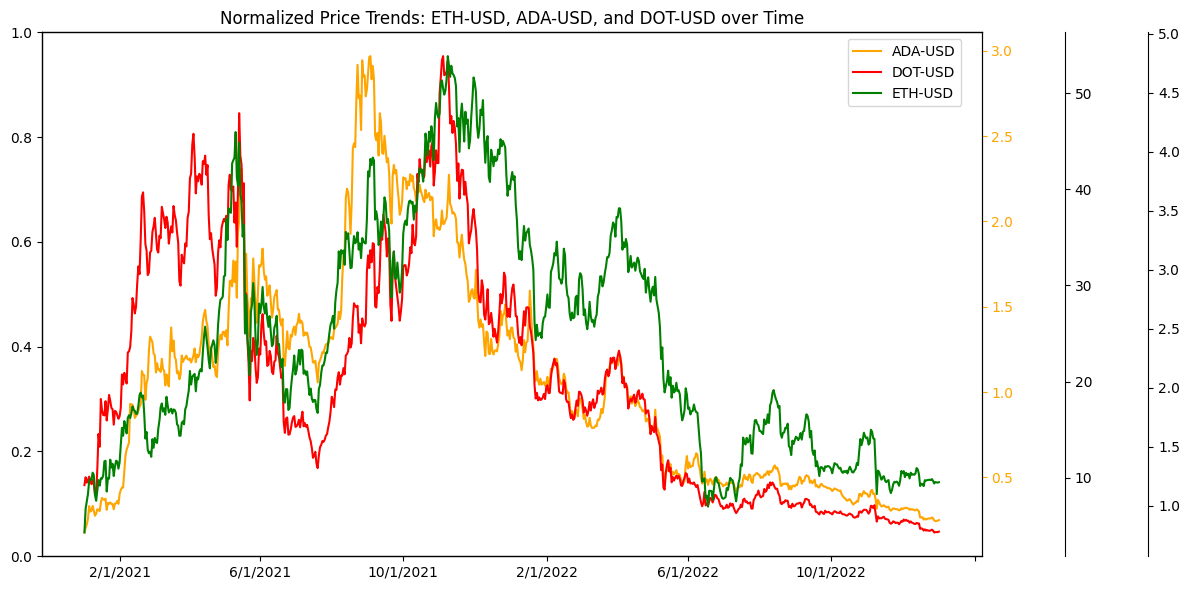

In [34]:
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import numpy as np

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot ADA-USD on the right y-axis
ax2 = ax1.twinx()
ax2.plot(data["dates"], eth["ada"], label='ADA-USD', color='orange')
ax2.set_ylabel('', color='orange')  # Remove y-axis label for ADA-USD
ax2.tick_params('y', colors='orange')

# Plot DOT-USD on the right y-axis
ax3 = ax1.twinx()
ax3.plot(data["dates"].index, eth["dot"], label='DOT-USD', color='red')
ax3.set_ylabel('', color='red')  # Remove y-axis label for DOT-USD
ax3.spines['right'].set_position(('outward', 60))

# Plot ETH-USD on the right y-axis
ax4 = ax1.twinx()
ax4.plot(data["dates"].index, eth["close_eth"], label='ETH-USD', color='green')
ax4.set_ylabel('', color='green')  # Remove y-axis label for ETH-USD
ax4.spines['right'].set_position(('outward', 120))

# Add legend
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax4.legend(lines2 + lines3 + lines4, labels2 + labels3 + labels4, loc='upper left', bbox_to_anchor=(0.85, 1.0))

plt.gca().xaxis.set_major_locator(MonthLocator(bymonthday=-1, interval=4))
plt.title('Normalized Price Trends: ETH-USD, ADA-USD, and DOT-USD over Time')

fig.tight_layout()
plt.show()

In [35]:
eth["dates"] = pd.to_datetime(eth["dates"])
eth = eth.sort_values(by="dates")

In [36]:
#drop dates after sorting
dates = eth["dates"][-141:]
eth = eth.drop(["dates"],axis =1)

In [43]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(eth, test_size=0.20, shuffle=False)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


Y_train = df_train['close_eth'].tolist()
Y_test = df_test['close_eth'].tolist()

X_train = df_train.drop("close_eth",axis=1)
X_test = df_test.drop("close_eth",axis=1)

print("Training set has {} observations.".format(len(X_train)))
print("Test set has {} observations.".format(len(X_test)))

Training set has 584 observations.
Test set has 146 observations.


In [44]:
def to_sequences(seq_size, X, y):
    x_seq = []
    y_seq = []

    for i in range(len(X)-SEQUENCE_SIZE):
        window = X[i:(i+SEQUENCE_SIZE)].values
        after_window = y[i+5]
        window = [[x_seq] for x_seq in window]
        #print("{} - {}".format(window,after_window))
        x_seq.append(window)
        y_seq.append(after_window)

    return np.array(x_seq),np.array(y_seq)

In [45]:
SEQUENCE_SIZE = 5
X_train,y_train = to_sequences(SEQUENCE_SIZE,X_train,Y_train)
X_test,y_test = to_sequences(SEQUENCE_SIZE,X_test,Y_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2] * X_train.shape[3]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2] * X_test.shape[3]))

print("Shape of training set: {}".format(X_train.shape))
print("Shape of test set: {}".format(X_test.shape))

Shape of training set: (579, 5, 5)
Shape of test set: (141, 5, 5)


In [46]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [47]:
def build_model(input_shape,head_size,num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0,mlp_dropout=0,):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [48]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[],
    mlp_dropout=0.3,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

In [49]:
import tensorflow as tf
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [50]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, \
    restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)

Epoch 1/200
8/8 [==============================] - 12s 133ms/step - loss: 3.2446 - val_loss: 0.0661
Epoch 2/200
8/8 [==============================] - 0s 23ms/step - loss: 2.4591 - val_loss: 0.2049
Epoch 3/200
8/8 [==============================] - 0s 22ms/step - loss: 2.1129 - val_loss: 0.4573
Epoch 4/200
8/8 [==============================] - 0s 26ms/step - loss: 1.7033 - val_loss: 0.7390
Epoch 5/200
8/8 [==============================] - 0s 22ms/step - loss: 1.5109 - val_loss: 0.9885
Epoch 6/200
5/5 [==============================] - 0s 38ms/step - loss: 0.0680


0.06802982091903687

In [51]:
pred = model.predict(X_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

5/5 [==============================] - 1s 8ms/step
Score (RMSE): 0.2608252635006424


In [52]:
mse_score = metrics.mean_squared_error(pred, y_test)
print("MSE Score: {}".format(mse_score))

MSE Score: 0.06802981808017952


In [53]:
mape_score = np.mean(np.abs((y_test - pred) / y_test)) * 100
print("MAPE Score: {}".format(mape_score))

MAPE Score: 18.143341931134326


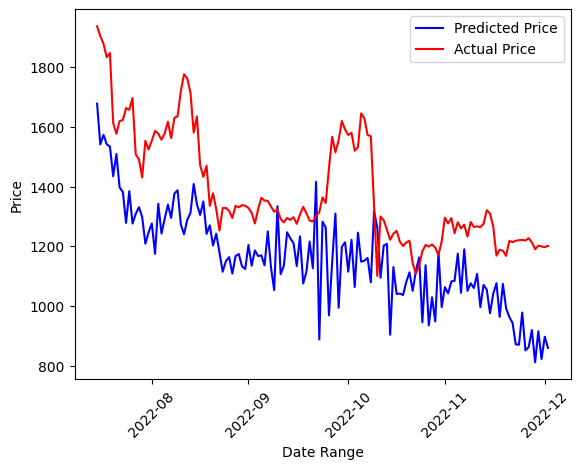

In [54]:
# Plot predicted and actual prices
plt.plot(dates, pred[-141:] * 1000, label='Predicted Price', color='b')
plt.plot(dates, y_test[-141:] * 1000, label='Actual Price', color='red')

plt.xlabel('Date Range')
plt.ylabel('Price')
plt.legend()

# Show dates after every two months
plt.gca().xaxis.set_major_locator(MonthLocator(bymonthday=-1, interval=1))

# Rotate x-axis labels for better presentation
plt.xticks(rotation=45)

plt.show()

In [56]:
predicted = pd.DataFrame(pred,columns=["values"])
predicted["dates"] = np.array(dates)
predicted.to_csv("Sentiments+Corr+Ethprices.csv")